* Machine learning models can learn the statistical latent space of images, music, and stories, and they can then sample from this space.

* Examples
  * Language model: https://openai.com/blog/better-language-models/
  * Music generation: https://magenta.tensorflow.org/groovae
  * Style-based image generation: https://www.youtube.com/watch?v=kSLJriaOumA

* In this chapter, we will explore
  * Text generation with LSTM
  * Variational autoencoders
  * Generative adversarial networks

<pre>랭귀지 모델의 간단한 버전 생성형 ver.
인풋을 변형해서 새로운 데이터 생성.
만화로 바꾸는거.


## Text generation with LSTM

### How do you generate sequence data?


<pre>text는 squence인데 sequence의 하나의 element가 tocken
다음 tocken을 prediction 하도록 train 하는 모델이 language model

* Train a network to predict the next token or next few tokens in a sequence, using the previous tokens as input.

* When working with text data, tokens are typically words or characters, and any network that can model the probability of the next token given the previous ones is called a language model.

* A language model captures the latent space of language: its statistical structure.

* Once you have such a trained language model, you can sample from it.
  * You feed it an initial string of text (called conditioning data), ask it to generate the next character or the next word, add the generated output back to the input data, and repeat the process many times.
  <pre>
  sampling strastegy -> 가장 높은 확률만 뽑지 않도록 추가
  
  <img src="https://drive.google.com/uc?id=1BuR76rTTrhrUTaYbcvynr_ag1M0_gCxn" width="800">
  
  

### The importance of the sampling strategy

* A naive approach is greedy sampling.
  * It always chooses the most likely next character.
  
* A more interesting approach is to introduce randomness in the sampling process.
  * This is called stochastic sampling.
  * We need a way to control the amount of randomness.
  * To do so, we will introduce a parameter called the softmax temperature that characterizes the entropy of the probability distribution used for sampling.
  <pre> temperature : 모델의 output에 softmax 씌우기 전에,, temperature을 나눠주면, proba distribution이 바뀜
  temperature가 커지면 퍼진다, uniform
  entropy -> 무질서 -< 커진다.
  왜? 온도가 커지면 활발해지니까 : 무질서해진까

  softmax에 t를 나눠준다
  exp(z) -> exp(z/t)
  t가 커지면 flat해진다.
    proba distribution


  ```python
  import numpy as np

  def reweight_distribution(original_distribution, temperature=0.5):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)
  ```
  
  <img src="https://drive.google.com/uc?id=1Bmgy-T_LAHsWn41Q2k1MAVsQJXg3ywKn" width="800">

### Character-level LSTM for text generation

In [ ]:
# preparing the data

from tensorflow.keras import utils
import numpy as np

path = utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('Corpus length:', len(text))

Corpus length: 600893


In [ ]:
print(text[:300])

preface


supposing that truth is a woman--what then? is there not ground
for suspecting that all philosophers, in so far as they have been
dogmatists, have failed to understand women--that the terrible
seriousness and clumsy importunity with which they have usually paid
their addresses to truth, ha


<pre>
upposing that truth 가 x , is가 y

* We will extract partially overlapping sequences of length `maxlen`, one-hot encode then, and pack them in a 3D Numpy array `x` of shape `(sequences, maxlen, unique_characters)`.

* Also, we will prepare an array `y` containing the corresponding targets: the one-hot-encoded characters that come after each extracted sequence.

In [ ]:
# Length of extracted character sequences
maxlen = 60
# 60개의 캐릭터
# We sample a new sequence every `step` characters
step = 3
# 3개씩 자른다
# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []
# 다음 캐릭터를 여기에 받아 놓는다.

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))
# 3번째가 1인 원핫벡터로 인코딩.
# 3D 텐서 형태로 이제 만든다.



# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 200278
Unique characters: 57
Vectorization...


3개씩 잘랐으니 1/3
문장기호 그런거 다 포함해서 vocabulary 크기가 57이란 얘기다.

* Building the network

In [ ]:
from tensorflow.keras import layers, models, optimizers

model = models.Sequential()
model.add(layers.LSTM(128, input_shape=(60, 57)))
model.add(layers.Dense(57, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               95232     
                                                                 
 dense (Dense)               (None, 57)                7353      
                                                                 
Total params: 102585 (400.72 KB)
Trainable params: 102585 (400.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras import layers, models, optimizers

model = models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax')) # 다음 단어를 예측하기 위한  dense
#output node는 57개 (vocabulary크기) 그 중 확률이 높은거 하나 classfier

optimizer = optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)# 분류 문제니까 categorycal

* Training the language model and sampling from it

In [ ]:
# sample the next character given the model's predictions
# 하나의 tocken을 sampling (temperature로 나눠줬던 그거)
def sample(preds, temperature=1.0):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1 )#랜덤으로 sampling 하는 부분이 여기, 분포로부터 샘플링
  return np.argmax(probas)

In [ ]:
import random
import sys

for epoch in range(1, 20):
  print('epoch', epoch)
  model.fit(x, y, batch_size=128, epochs=1)
# 첫번째랑 마지막 가지고 generation을 해본다.
  if epoch == 1 or epoch == 19:
    start_index = random.randint(0, len(text)-maxlen-1)
    generated_text = text[start_index: start_index+maxlen]
    print('--- Generating with seed: "' + generated_text + '"')

    for temperature in [0.2, 0.5, 1.0, 1.2]:
      print('------ temperature: ', temperature)
      sys.stdout.write(generated_text)

      # generate 400 characters
      for i in range(400):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
          sampled[0, t, char_indices[char]] = 1.
        # 여기가 generate하는 부분
        # 57개의 prediction이 나옴
        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
      print()

epoch 1
1565/1565 [==============================] - 12s 6ms/step - loss: 2.5820
--- Generating with seed: "tom of all
this.


128

=promises of wisdom.=--modern scienc"
------ temperature:  0.2
tom of all
this.


128

=promises of wisdom.=--modern science the the the the sore the the the the the the the the the the the the the the the the the ser the the the the the the and the the the the the the the sere the the the and the the the the the the the the the the sere the the the the the the the the the the the the the the the liting the the in the the the the the the the the the the the the the in the the the the the the the the the the the the th
------ temperature:  0.5
he the in the the the the the the the the the the the the the to the in time the 
he als casond in the send the sapal to lis the the re it the the the dith he che pesy of masinge time ta de the se thace the in and and the sot in the al ig taly ond pretiche s the soming, of in the the the ss ind an are the ther the the

temerature가 높아지면, diversity는 커졌지만 너무 중구난방
GPT의 학습 방식은 이거랑 똑같다.
lstm대신 transformer를 쓰면 그렇게 됨

## Generating images with variational autoencoders

모든 model의 문제는 분포를 추정하는 것.
이미지 데이터의 분포를 추정 할 수 있게 되었다.

* *\"What I cannot create, I do not understand\"* - Richard Feynman

* Sampling from a latent space of images to create entirely new images or edit existing ones
  * The techniques are not specific to images.


>### Sampling from latent spaces of images

<pre>inputspace에서 sampling하기 어려움
작은 차원의 공간으로 mapping 해서 거기서 뽑으면 수월하지 않을까?
작은 차원 : Latent space
여기서 뽑아서
input space에서 복원시켜줌

* The key idea
  * Develop a low-dimensional latent space of representations where any point can be mapped to a realistic-looking image.
  
* Generator or decoder
  * The module takes as input a latent point and outputs an image.
  
   <img src="https://drive.google.com/uc?id=17u5Er8I1qqB3laoHhM6k3V-U3HaSIlBs" width="800">
  
* Two popular approaches: variational autoencoders (VAEs) and generative adversarial networks (GANs)

  <img src="https://drive.google.com/uc?id=17y_hX8vKsfsQuFqHikncuiij8gxdquf8" width="800">
  
* The concept vector
  * The idea of a concept vector is very similar to that of word embeddings.
  * Given a latent space of representations, or an embedding space, certain directions in the space may encode interesting axes of variation in the original data.
  
   <img src="https://drive.google.com/uc?id=17wqcRl5q6ChI0jvEUDZgjIYLkQ8MFLve" width="800">
  

워드임베딩에서 봤던 비슷한 현상을 발견할 수 있음

latence space 벡터공간의 특정 방향들이 특정 정보를 담고 있음 concept vector(조절하면 웃는다던지 그런거)

>### Variational autoencoders

autoencoder의 생성버전
encoder는 차원 쭐임
decoder은 원래 벡터로 늘림


* Autoencoders with Bayesian inference

* A classical autoencoder takes an input, maps it to a latent vector space via an encoder module, and then decodes it back to an output with the same dimensions as the input via a decoder module.
<pre> 원래 이미지로 복원할 수 있게 encoder와 decoder를 학습
일종의 압축
여기에 제약을 걸어준다고 한다.
  <img src="https://drive.google.com/uc?id=17xJz97hv18a3PrId5yD6_0XNaIMHcfZ0" width="800">

* A VAE turns the image into the parameters of a statistical distribution, a mean and a variance, instead of compressing its input image into a fixed code in the latent space.
  * The VAE then uses the mean and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input.
  
  <img src="https://drive.google.com/uc?id=17zJB7PMYqIfEtVmF6skwRuTCTlJnI0c0" width="800">
  <pre>
  latent 공간에 제약을 가해준게 VAE
  인코더는 평균과 분산을 뽑아주면 됨
  인코더는 학습 데이터를 받아서 가우시안에 매핑
  디코더는 가우시안 분포 가지고 다시 원복 시킴.
  그럼 실제 이미지를 만들어 낼 수 있게 되는거임.
  
  가우시안의 평균과 분산인 , z_mean, z_log_variance
   
   가우시안 분포라는 제약 조건이 추가됨
   loss도 가우시안으로 학습되게끔 loss가 두 개임.
  
* How a VAE works:
  * An encoder module turns the input samples `input_img` into two parameters in a latent space of representations, `z_mean` and `z_log_variance`.
  * You randomly sample a point `z` from the latent normal distribution that's assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon` where `epsilon` is a random tensor of small values.
  * A decoder module maps this point in the latent space back to the original input image.
  
* Because `epsilon` is random, the process forces the latent space to be continuously meaningful.

* The VAE is trained via two loss functions:
  * a reconstruction loss that forces the decoded samples to match the initial inputs
  * a regularization loss that helps learn well-formed latent spaces and reduce overfitting to the training data
  
* How it can be implemented:

  ```python
  z_mean, z_log_variance = encoder(input_img)

  z = z_mean + exp(z_log_variance) * epsilon

  reconstructed_img = decoder(z)

  model = Model(input_img, reconstructed_img)
  ```

In [ ]:
# Create a sampling layer

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Input, Model

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # 표준정규분포로부터 sample
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # sample을 만들어주는 코드

In [ ]:
# Encoder network

latent_dim = 2

encoder_inputs = Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x) # multioutput
z_mean = layers.Dense(latent_dim, name="z_mean")(x) # 하나는 평균을 뽑아주는거
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x) # var을 뽑아주는 layer
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

In [ ]:
# Decoder network
# sample z를 받아서 원복 시켜주는 코드
latent_inputs = Input(shape=(latent_dim,)) # 2dimension을 입력으로 받음
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) #conv는 원래는 뫄주는 역할,, 특징 벡터를 뽑아주는거 Decoder는 이거의 반대작용 Conv2D 의 반대작용.
# 반대 작용이라고 보면 됨. scalar를 matrix로 mapping 해주면 되는거임. upsampling 활용을 할 떄 쓰는 layer
# stride 2를 주면 2배 커
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

표준 정규 분포의 랜덤 값을 decoder에 넣어주면 이미지를 생성

두 loss를 minimize
reconstruct는 쭉 따라가며 서 backpropa
kl가지곤 encoder

decoder는 reconstruction 가지고만 update
encoder는 둘 다. 영향을 미침
어차피 더해서 backpropa하면 되어서 한번만 하면 됨
Loss weight를 적절히 줘야함.
k1에만 주면 decoder가 생성을 잘 못하고 그러니까 ㅇㅇ

In [ ]:
# Define VAE as a model with a custom train_step
from tensorflow.keras import losses, optimizers

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                losses.binary_crossentropy(data, reconstruction)
            ) # 두 개의 loss를 계산함,(입력이랑 얼마나 비슷한지)
            reconstruction_loss *= 28 * 28
            # regularization loss 역할, 평균과 분산을 가지고 가우시안 분포를 정의할 수 있는데,
            # 평균이 0이고 표준편차가 1인 표준 정규분포와 비슷해야한다는 loss
            # 분포 사이의 거리.
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights) #gradient 계싼하는 부분
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

* The Kullback-Leibler divergence `KL(Q|P)`
  * The KL divergence tells us how well the probability distribution `Q` approximates the probability distribution `P`.
  * It measures the similarity (or dissimilarity) between two probability distributions.
  * In VAEs, we assume that `P` is Gaussian with zero mean and unit variance.

분포간의 거리가 얼마나 유사하고 얼마나 떨어져있느냐를 재는 척도

In [ ]:
# Training the VAE

from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/30
547/547 [==============================] - 11s 10ms/step - loss: 203.7981 - reconstruction_loss: 201.3798 - kl_loss: 2.4183
Epoch 2/30
547/547 [==============================] - 4s 8ms/step - loss: 168.2353 - reconstruction_loss: 165.1197 - kl_loss: 3.1155
Epoch 3/30
547/547 [==============================] - 5s 9ms/step - loss: 159.9381 - reconstruction_loss: 156.7376 - kl_loss: 3.2005
Epoch 4/30
547/547 [==============================] - 5s 8ms/step - loss: 156.3601 - reconstruction_loss: 153.0551 - kl_loss: 3.3051
Epoch 5/30
547/547 [==============================] - 4s 8ms/step - loss: 154.0160 - reconstruction_loss: 150.6120 - kl_loss: 3.4040
Epoch 6/30
547/547 [==============================] - 5s 9ms/step - loss: 152.6103 - reconstruction_loss: 149.1751 - kl_loss: 3.4352
Epoch 7/30
547/547 [==============================] - 4s 8ms/step - loss: 151.4672 - reconstruction_loss: 147.9809 - kl_loss: 3.4864
Ep

k1_loss는 평균0 분산 1으로 맞춰줌
Decoder는 reconstruction
output을 일정 범위로 모아주려고 하는거임.

1/1 [==============================] - 0s 17ms/step


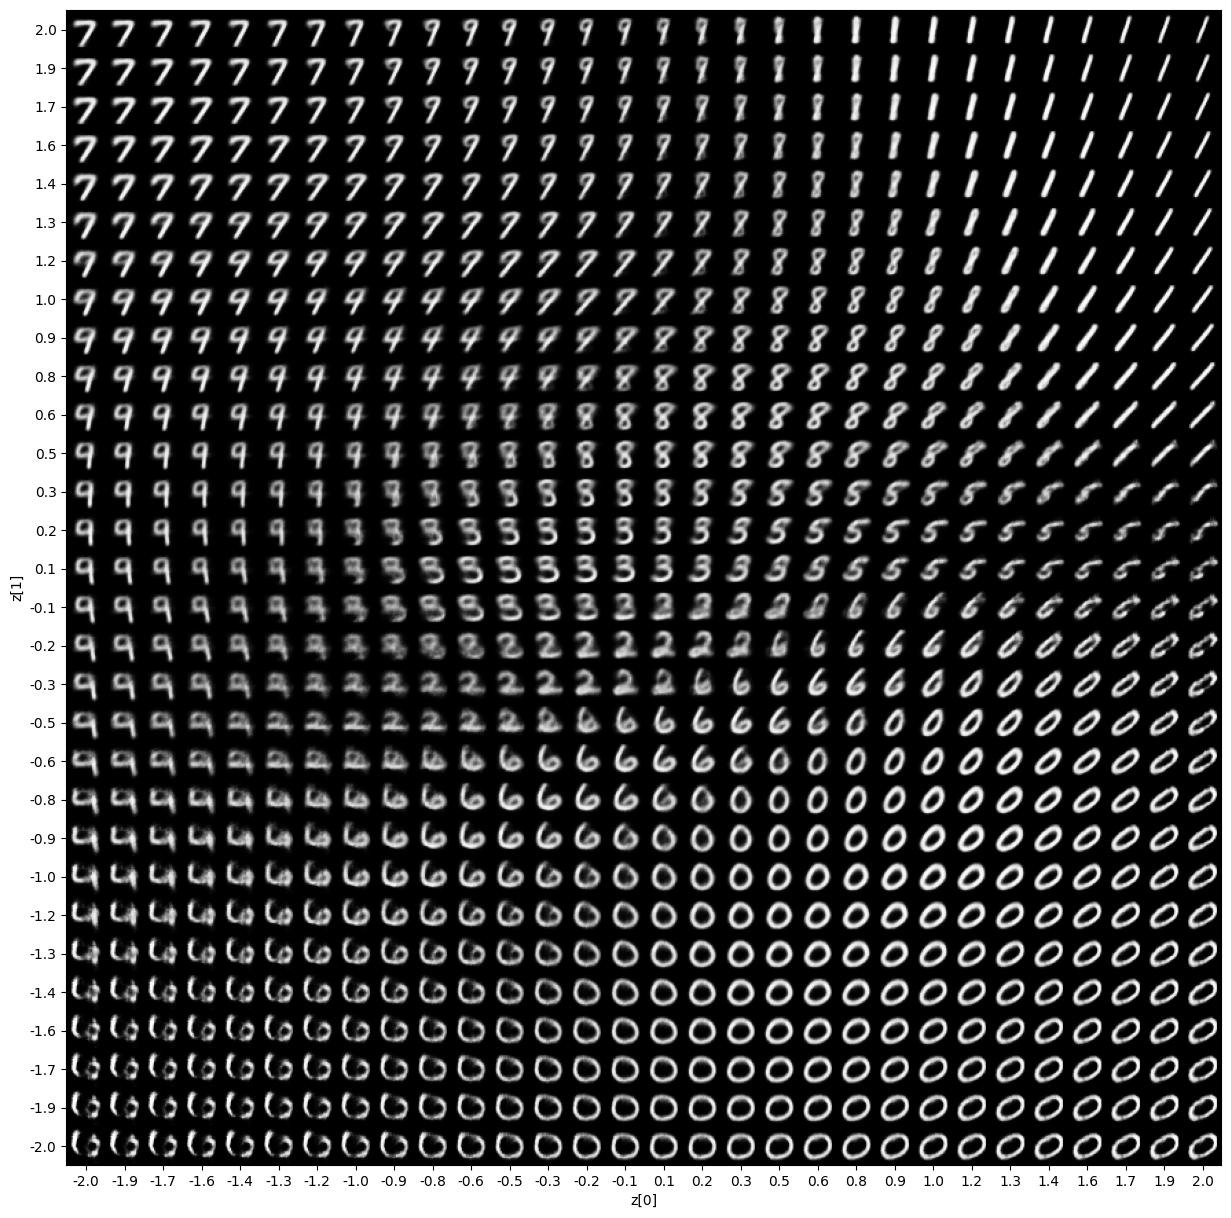

In [ ]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

## Introduction to generative adversarial networks

<pre>목표랑 다른 형태를 가지고 있음
loss를 줄이려고 했다면, loss surface에서
saddle point를 찾으려고함

Generator : random vector를 받아서 실제 이미지를 생성하려고 하는애
Discrimitator : image를 입력으로 받아서 진짜인지, 가짜인지 two class로 분류하는 network

두개의 componet가 엮여서 어떻게 학습이 되는가??

Gnerator가 random vector를 받아서, image 크기의 output을 생성.
생성된 이미지와 진짜 이미지를 가져다가 Discrimitator가 진짜인지 가짜인지 판별
1과 0을 구분하도록 학습.

Generator는 어떻게 학습??
Discrimitatior가 진짜로 판단 하도록 generator를 학습.
Discriminator의 Output 이용을 함.

위조 지폐범과 감별사의 예시를 들어보자.
감별사를 속이는 방향으로 위조지폐범을 학습시킨다.

결국엔 어떻게 되느냐?
G는 D를 속일 수 있게 됨.
D는 구분을 할 수 없게 된다.
이렇게 학습된 G를 가지고 real image를 학습하면 된다.

D의 loss가 0을 되면 안됨. 왜? 너무 잘 구분하니까.
우리의 최종 목표는 G가 D를 잘 속여야해.

얘는 minimum을 찾는게 아니라 적절한 지점을 찾아야함.

사이즈가 큰 image를 생성하려면 온갖 trick을 넣어야한다.


* Generative adversarial networks (GANs) introduced in 2014 by Goodfellow et al.
  * an alternative to VAEs for learning latent spaces of images
  
* GAN consists of two parts:
  * Generator network : takes as input a random vector (a random point in the latent space), and decodes it into a synthetic image.
  * Discriminator network : takes as input an image (real or synthetic), and predicts whether the image came from the training set (real) or was created by the generator network (fake).
  
* The generator network is trained to be able to fool the discriminator network, at the same time the discriminator network is trained to distinguish between real or fake.

  <img src="https://drive.google.com/uc?id=17l0HmcJ7BaQ0F81HIj2Fe6bOaFeZtEVr" width="800">

* GAN is a system where the optimization minimum isn't fixed.
  * It's a dynamic system where the optimization process is seeking not a minimum, but an equilibrium between two forces.
  * For this reason, GANs are difficult to train.

> ### Schematic GAN implementation

* Deep convolutional GAN (DCGAN)
  * a GAN where the generator and discriminator are deep convnets.
  
* We will train the GAN on "flog" images from CIFAR10.
  * a dataset of 50,000 32\*32 RGB images belonging to 10 classes.
  
* Schematically, the GAN looks like:
  * A `generator` maps vectors of shape `(latent_dim,)` to images of shape `(32,32,3)`.
  * A `discriminator` maps images of shape `(32,32,3)` to a binary score estimating the probability that the image is real.
  Binary를 받아줌.
  * A `gan` network chains the generator and the discriminator together.
    * `gan(x) = discriminator(generator(x))` 이렇게 엮인 상태로 정의할 수 있음.
  * We train the discriminator using examples of real and fake images along with "real"/"fake" labels.
  * To train the generator, we use the gradients of the generator's weights with regard to the loss of the `gan` model.
    * To be specific, we move the weights of the generator in a direction that makes the discriminator more likely to classify as "real" the images decoded by the generator.
    D가 입력한 가짜 이미지가 real로 판단하도록 학습을 시키면 된다.

> ### The generator

* A `generator` model that turns a (random) vector into a candidate image.

In [ ]:
from tensorflow.keras import layers, Input, models, optimizers
import numpy as np
# latent vector dim
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 3-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = models.Model(generator_input, x)
generator.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_6 (Dense)             (None, 32768)             1081344   
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 32768)             0         
                                                                 
 reshape_3 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 256)       1048

> ### The discriminator

* A `discriminator` model that takes as input a candidate image (real or synthetic) and classifies it into one of two classes: "generated image" or "real image from the training set".

In [ ]:
discriminator_input = Input(shape=(height, width, channels)) # 32 32 32를 input으로 받아
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use a weight decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = optimizers.legacy.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8) # clipvalue = gradient가 너무 크면 줄이는 역할
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6, 6, 128)         0   

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


> ### The adversarial network

Discriminator : freeze 시켜줘야함.
layer의 parameter

* Training `gan` will update the weights of `generator` in a way that makes `discriminator` more likely to predict "real" when looking at fake images.

* Very important to note that you set the discriminator to be frozen during training `gan`!

In [ ]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False # 학습 안되게 선언

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input)) # generator가생성을하면 discriminator로 간다. generator만 학습 시키면 됨.
gan = models.Model(gan_input, gan_output)

gan_optimizer = optimizers.legacy.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

> ### How to train DCGAN

1.   Draw random points in the latent space (random noise).
2.   Generate images with `generator` using this random noise.
3.   Mix the generated images with real ones.
4.   Train `discriminator` using these mixed images, with corresponding targets.
5.   Draw new random points in the latent space.
6.   Train `gan` using these random vectors, with targets that all say "these are real images."

<pre>어떻게 학습 시킬까?

random한 vector를 뽑아
G에 넣어
이미지 생성 돼
진짜 이미지랑 가짜 이미지랑 합쳐
D에 넘겨줘
D 학습을 시켜
다시 random vector 뽑아
G에 넣어
output을 real이라고 학습 되도록 계속 학습 시키면 됨.

In [ ]:
import os
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = '/content'

# Start training loop
### 이게 중요해!
# for문은 G,D 한 번씩 업데이트 되는거.
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors) # 생성한 이미지를 얻어.

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))]) # 가짜 이미지엔 1, 진짜 이미지엔 0 GroundTruth

    # Add random noise to the labels -- trick
    labels += 0.05 * np.random.random(labels.shape) # scale을 확 쭐여 0,1에다가 더해 random추가.

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels) # D를 학습 시켜

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim)) # 다시 random한걸 뽑아.

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1)) # 가짜 이미지를 줘놓고 D한테 이걸 0이라 예측해야해 라고 signal을 줌. 모두 0이라고 붙줘

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets) # D가 0으로 (GT가 real)예측하도록, G를 업데이트.

    from tensorflow.keras.losses import BinaryCrossentropy

    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))
        print(BinaryCrossentropy()(misleading_targets, gan(random_latent_vectors, training=False)))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 17ms/step
discriminator loss at step 5200: 0.6927359700202942
adversarial loss at step 5200: 0.777093768119812
tf.Tensor(0.7594491, shape=(), dtype=float32)
1/1 [==============================] - 0s 17ms/step
discriminator loss at step 5300: 0.6809054017066956
adversarial loss at step 5300: 0.6801804900169373
tf.Tensor(0.59355754, shape=(), dtype=float32)
1/1 [==============================] - 0s 17ms/step
discriminator loss at step 5400: 0.7031505703926086
adversarial loss at step 5400: 0.7978997826576233
tf.Tensor(0.72031254, shape=(), dtype=float32)
1/1 [==============================] - 0s 19ms/step
discriminator loss at step 5500: 0.6877260208129883
adversarial loss at step 5500: 0.716241180896759
tf.Tensor(0.6762311, shape=(), dtype=float32)
1/1 [==============================] - 0s 18ms/step
discriminator loss at step 5600: 0.6748934388160706
adversarial loss at step 5600: 0.7969145774841309
tf.Tensor(

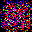

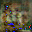

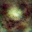

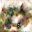

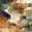

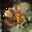

In [ ]:
from IPython.display import Image, display

display(Image('generated_frog0.png', width=128, height=128))
display(Image('generated_frog2000.png', width=128, height=128))
display(Image('generated_frog4000.png', width=128, height=128))
display(Image('generated_frog6000.png', width=128, height=128))
display(Image('generated_frog8000.png', width=128, height=128))
display(Image('generated_frog9900.png', width=128, height=128))

1/1 [==============================] - 1s 716ms/step


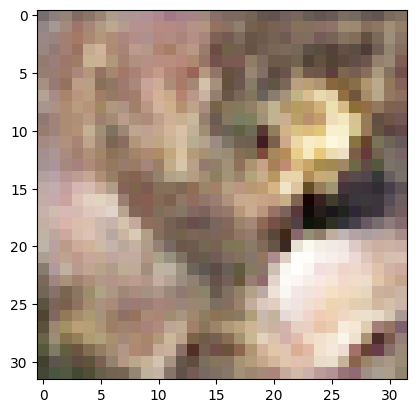

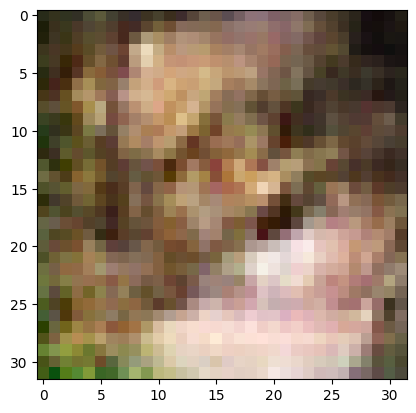

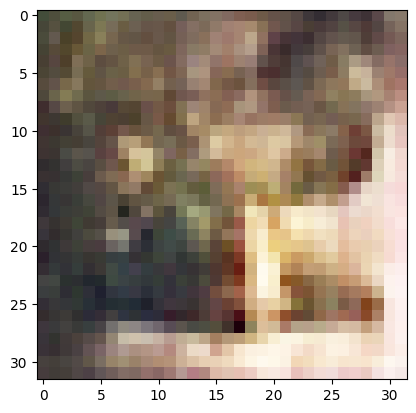

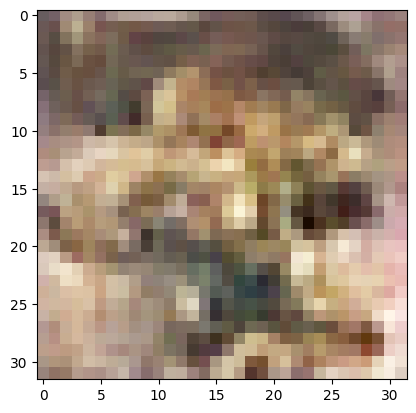

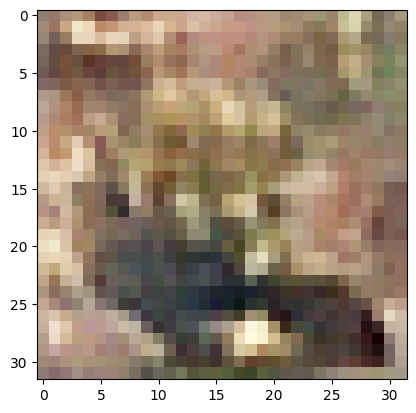

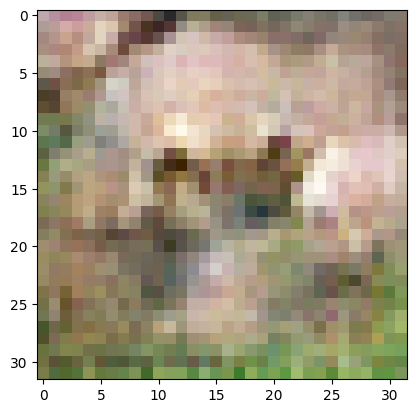

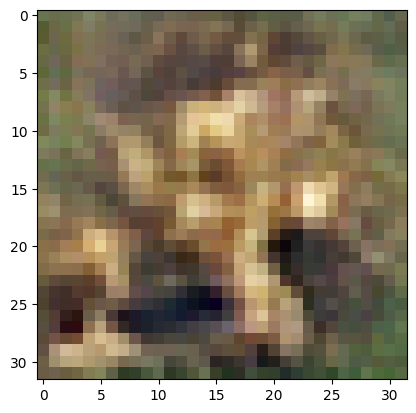

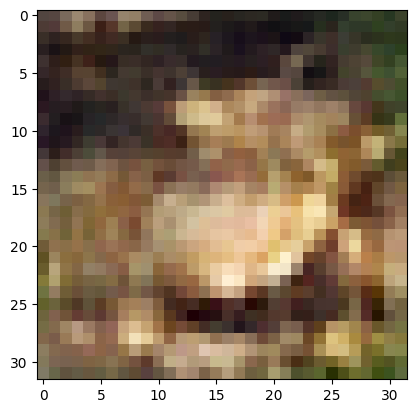

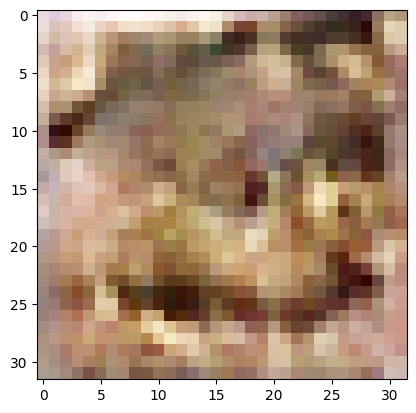

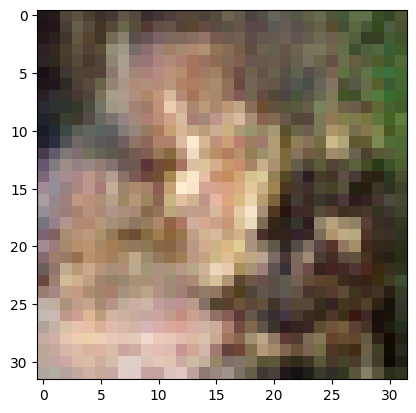

In [ ]:

import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=True)
    plt.figure()
    plt.imshow(img)

plt.show()
plt.close()


   <img src="https://drive.google.com/uc?id=17zjzuV5yA-mffuW--XwhXkj-UVxygMvH" width="800">